Topic Classification - Buildign Two Different Approaches

 Loading training data...
Training data loaded: 57402 samples
Label distribution:
label
movie     50000
book       4992
sports     2410
Name: count, dtype: int64

 Test data loaded: 18 samples
Test data columns: ['sentence_id', 'sentence', 'sentiment', 'topic']
Test label distribution
topic
sports    6
book      6
movie     6
Name: count, dtype: int64

Approach 1: Rule-Based Classifier

 Building Rule-Based Classifier...

 Testing Rule-Based Classifier on training sample...
Rule-Based Training Accuracy: 0.864

 Testing Rule-Based Classifier on test data...
Rule-Based Test Accuracy: 0.778

 Rule-Based CLassification Report:
              precision    recall  f1-score   support

        book       1.00      0.67      0.80         6
       movie       0.80      0.67      0.73         6
      sports       0.67      1.00      0.80         6

    accuracy                           0.78        18
   macro avg       0.82      0.78      

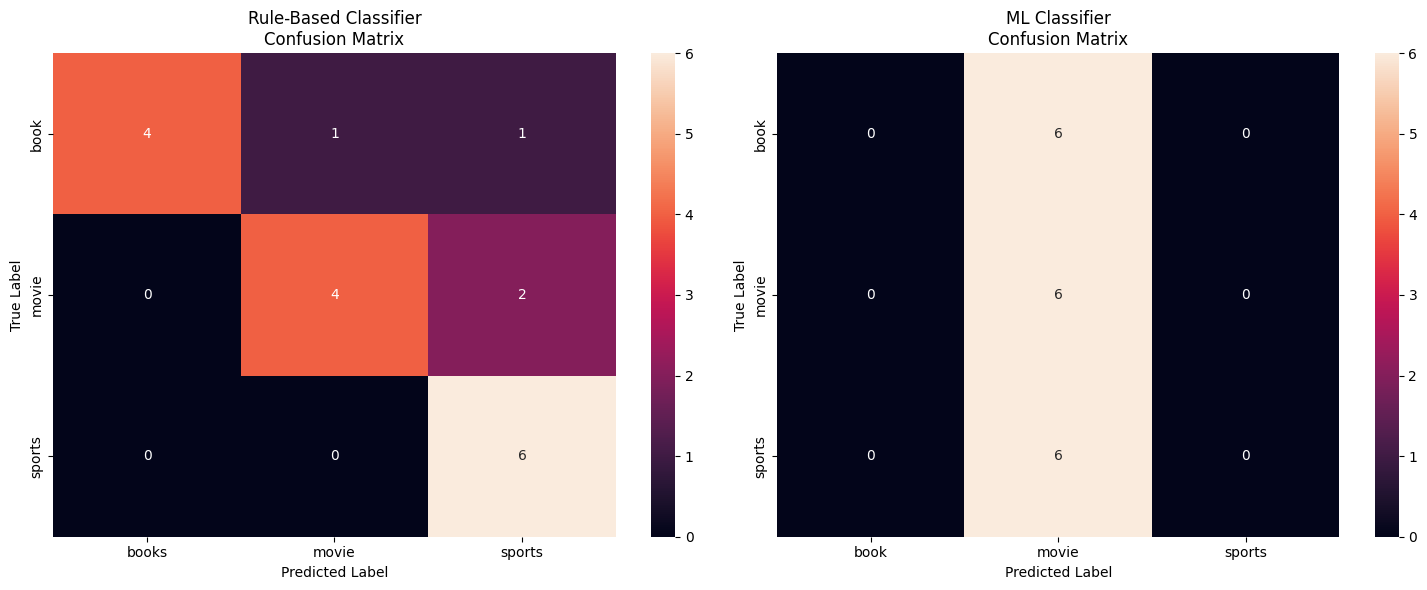


 Confusion matrices saved as 'confusion_matrices.png'

Error Analysis

 Analyzing misclassifications...

 Error Statisctics:
Rule-based errors: 4
ML errors: 12
Both methods wrong: 2

 Example misclassifications (both methods wrong):

 True: book | Rule predicted: sports | ML predicted: movie
  Text: I enjoyed the way the timelines shifted, even if it got a little confusing sometimes....
--------------------------------------------------------------------------------

 True: book | Rule predicted: movie | ML predicted: movie
  Text: I found the main character so annoying that it was hard to care about what happened next....
--------------------------------------------------------------------------------


In [10]:
import pandas as pd
import numpy as np 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

print("Topic Classification - Buildign Two Different Approaches")
print("=" * 60)

# 1. load and prepare data
print("\n Loading training data...")

# load combined data
training_data = pd.read_csv('/Users/hanakaraibrahimovic/Documents/VU/Text Mining for AI/final_training_data.csv')
print(f"Training data loaded: {len(training_data)} samples")
print(f"Label distribution:")
print(training_data['label'].value_counts())

# load test data
test_data = pd.read_csv('/Users/hanakaraibrahimovic/Documents/VU/Text Mining for AI/sentiment-topic-test.tsv',
                        sep='\t') # TSV file uses tabs
print(f"\n Test data loaded: {len(test_data)} samples")
print(f"Test data columns: {list(test_data.columns)}")
print(f"Test label distribution")
print(test_data['topic'].value_counts())

# 2. approach 1: rule-based classifier
print("\n" + "=" * 60)
print("Approach 1: Rule-Based Classifier")
print("=" * 60)

class RuleBasedClassifier:
    def __init__(self):
        # defining keywords for each category
        self.sports_keywords = [
            'team', 'game', 'player', 'match', 'football', 'soccer', 'basketball',
            'baseball', 'tennis', 'goal', 'score', 'win', 'coach', 'league',
            'championship', 'tournament', 'stadium', 'field', 'court', 'sport',
            'athlete', 'competition', 'defeat', 'victory', 'champion', 'cup',
            'olympics', 'fifa', 'nba', 'nfl', 'premier'
        ]

        self.movie_keywords = [
            'film', 'movie', 'director', 'actor', 'actress', 'cinema', 'screen',
            'plot', 'character', 'scene', 'cast', 'starring', 'performance',
            'script', 'dialogue', 'filming', 'production', 'hollywood', 'oscar',
            'drama', 'comedy', 'thriller', 'horror', 'romance', 'documentary',
            'sequel', 'premiere', 'box office', 'review', 'critics', 'rating'
        ]

        self.book_keywords = [
            'book', 'novel', 'author', 'writer', 'chapter', 'page', 'read',
            'story', 'narative', 'character', 'plot', 'publisher', 'publication',
            'literature', 'fiction', 'non-fiction', 'biography', 'memoir',
            'bestseller', 'library', 'bookstore', 'manuscript', 'prose',
            'poetry', 'anthology', 'edition', 'paperback', 'hardcover'
        ]

    def predict_single(self, text):
        """Predict single text sample"""
        text_lower = text.lower()

        # count keywords matches for each category
        sports_score = sum(1 for word in self.sports_keywords if word in text_lower)
        movie_score = sum(1 for word in self.movie_keywords if word in text_lower)
        book_score = sum(1 for word in self.book_keywords if word in text_lower)

        # return category with highest score
        scores = {'sports': sports_score, 'movie': movie_score, 'book': book_score}
        return max(scores, key=scores.get)
    
    def predict(self, texts):
        """Predict multiple text samples"""
        return [self.predict_single(text) for text in texts]
    
    def get_feature_importance(self):
        """Return keywords used for classification"""
        return {
            'sports': self.sports_keywords,
            'movie': self.movie_keywords,
            'book': self.book_keywords
        }
    
# train and test Rule-Based Classifier
print("\n Building Rule-Based Classifier...")
rule_classifier = RuleBasedClassifier()

# test on training data - to see how it performs
print("\n Testing Rule-Based Classifier on training sample...")
train_sample = training_data.sample(n=1000, random_state=42) # sample for speed
rule_train_pred = rule_classifier.predict(train_sample['text'])
rulle_train_accuracy = accuracy_score(train_sample['label'], rule_train_pred)
print(f"Rule-Based Training Accuracy: {rulle_train_accuracy:.3f}")

# test on actual test data
print("\n Testing Rule-Based Classifier on test data...")
rule_test_pred = rule_classifier.predict(test_data['sentence'])
rule_test_accuracy = accuracy_score(test_data['topic'], rule_test_pred)
print(f"Rule-Based Test Accuracy: {rule_test_accuracy:.3f}")

print("\n Rule-Based CLassification Report:")
print(classification_report(test_data['topic'], rule_test_pred))

# 3. approach 2: machine learning classifier
print("\n" + "=" *60)
print("Approach 2: Machine Learning Classifier")
print("="*60)

print("\n Building ML Classifier with TF-IDF + Naive Bayes...")

# prepare training data
X_train = training_data['text']
y_train = training_data['label']

# create TF-IDF features
print("Creating TF-IDF features...")
tfidf = TfidfVectorizer(
    max_features=5000, # top 5000 features
    stop_words='english',
    ngram_range=(1, 2), # unigrams and bigrams
    min_df=2, # ignore terms that appear in less than 2 documents
    max_df=0.95 # ignore terms that appear in more than 95% of documents
)

X_train_tfidf = tfidf.fit_transform(X_train)
print(f"TF-IDF matrix shape: {X_train_tfidf.shape}")

# train Naive Bayes classifier
print("\n Training Naive Bayes classifier...")
nb_classifier = MultinomialNB(alpha=1.0)
nb_classifier.fit(X_train_tfidf, y_train)

# test on training data
train_sample_tfidf = tfidf.transform(train_sample['text'])
nb_train_pred = nb_classifier.predict(train_sample_tfidf)
nb_train_accuracy = accuracy_score(train_sample['label'], nb_train_pred)
print(f"ML Training Accuracy: {nb_train_accuracy:.3f}")

# test on actual test data
print("\n Testing ML Classifier on test data...")
X_test_tfidf = tfidf.transform(test_data['sentence'])
nb_test_pred = nb_classifier.predict(X_test_tfidf)
nb_test_accuracy = accuracy_score(test_data['topic'], nb_test_pred)
print(f"ML Test Accuracy: {nb_test_accuracy:.3f}")

print("\n ML Classification Report:")
print(classification_report(test_data['topic'], nb_test_pred))

# 4. comparison and analysis
print("\n" + "=" * 60)
print("Comparison and Analysis")
print('='*60)

# create comparison dataframe
comparison_df = pd.DataFrame({
    'Method': ['Rule-Based', 'Machine Learning'],
    'Training Accuracu': [rulle_train_accuracy, nb_train_accuracy],
    'Test Accuracy': [rule_test_accuracy, nb_test_accuracy]
})

print("\n Performance Comparison:")
print(comparison_df.to_string(index=False))

# confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# rule-based confusion matrix
cm_rule = confusion_matrix(test_data['topic'], rule_test_pred)
sns.heatmap(cm_rule, annot=True, fmt='d', ax=axes[0],
            xticklabels=['books', 'movie', 'sports'],
            yticklabels=['book', 'movie', 'sports'])
axes[0].set_title('Rule-Based Classifier\nConfusion Matrix')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# ML confusion matrix
cm_ml = confusion_matrix(test_data['topic'], nb_test_pred)
sns.heatmap(cm_ml, annot=True, fmt='d', ax=axes[1],
            xticklabels=['book', 'movie', 'sports'],
            yticklabels=['book', 'movie', 'sports'])
axes[1].set_title('ML Classifier\nConfusion Matrix')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('/Users/hanakaraibrahimovic/Documents/VU/Text Mining for AI/confusion_matrices.png',
            dpi=300, bbox_inches='tight')
plt.show()

print(f"\n Confusion matrices saved as 'confusion_matrices.png'")

# 5. error analysis
print("\n" + "=" * 60)
print("Error Analysis")
print("=" * 60)

# analyze misclassifications
print("\n Analyzing misclassifications...")

# create error analysis dataframe
error_analysis = pd.DataFrame({
    'text': test_data['sentence'],
    'true_label': test_data['topic'],
    'rule_pred': rule_test_pred,
    'ml_pred': nb_test_pred
})

# find examples where both methods disagree with true label
both_wrong = error_analysis[
    (error_analysis['true_label'] != error_analysis['rule_pred']) &
    (error_analysis['true_label'] != error_analysis['ml_pred'])
]

print(f"\n Error Statisctics:")
print(f"Rule-based errors: {sum(test_data['topic'] != rule_test_pred)}")
print(f"ML errors: {sum(test_data['topic'] != nb_test_pred)}")
print(f"Both methods wrong: {len(both_wrong)}")

# show some error examples
print(f"\n Example misclassifications (both methods wrong):")
for i, row in both_wrong.head(3).iterrows():
    print(f"\n True: {row['true_label']} | Rule predicted: {row['rule_pred']} | ML predicted: {row['ml_pred']}")
    print(f"  Text: {row['text'][:150]}...")
    print("-" * 80)



